In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
import random
%matplotlib inline

In [2]:
args = {'lr':0.01,
        'train epochs':500,
        'hidden layers':15,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        'big hidden layers':2,
        'big epochs':1000,
        'big lr':0.01
        }

# Data Prep

In [3]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [4]:
df = pd.read_excel('data_3nm.xlsx')

In [5]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [6]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [7]:
# scale for training
scaler = args['scaler']
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [8]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [9]:
# add noise
X_noisy = add_noise(X, args['noise'])

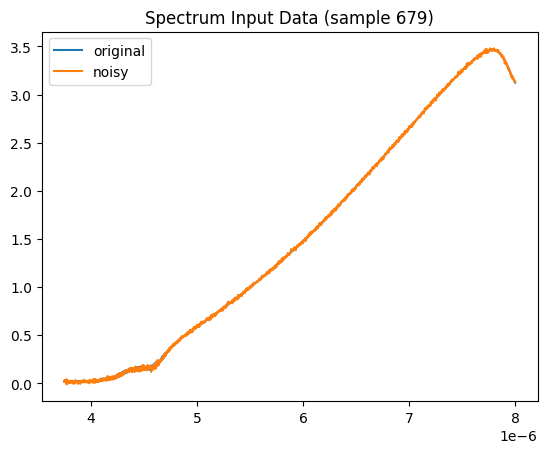

In [10]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [11]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [13]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

In [14]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [15]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [16]:
class BigNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(BigNet, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 11: hidden_size = 11
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [17]:
criterion = args['train criterion']

In [18]:
print("Individual Layer Training")
for layer in layers:
    features = X_train_tensor
    target = layer['y_train']

    # instantiate model
    model = FeedForward(features.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(features)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

Individual Layer Training
layer 1
hidden layer sizes: [1417, 1328, 1239, 1151, 1062, 974, 885, 797, 708, 619, 531, 442, 354, 265, 177, 88]
epoch: 50, loss = 40.248260498046875
epoch: 100, loss = 3.919325828552246
epoch: 150, loss = 2.5182745456695557
epoch: 200, loss = 2.3130147457122803
epoch: 250, loss = 2.088489532470703
epoch: 300, loss = 2.020618200302124
epoch: 350, loss = 1.861901044845581
epoch: 400, loss = 1.8916085958480835
epoch: 450, loss = 1.7792915105819702
epoch: 500, loss = 1.8221819400787354
best loss: 1.5755854845046997 in epoch 497

layer 2
hidden layer sizes: [1417, 1328, 1239, 1151, 1062, 974, 885, 797, 708, 619, 531, 442, 354, 265, 177, 88]
epoch: 50, loss = 37.56568908691406
epoch: 100, loss = 8.21823787689209
epoch: 150, loss = 5.996057033538818


KeyboardInterrupt: 

In [ ]:
big_net = BigNet(len(X.columns)+len(y.columns), len(y.columns), args['big hidden layers'])
optimizer = torch.optim.Rprop(big_net.parameters(), lr=args['big lr'])

best_loss = np.inf
best_epoch = 0
train_losses = []

features = X_train.copy()
features.index = range(len(features))

for layer in layers:
    pred = layer['model'](X_train_tensor)
    pred = pd.DataFrame(pred.detach().numpy(), columns=[f'{layer["col"]} predictions'])
    features = pd.concat([features, pred], axis=1)

features = torch.tensor(features.values, dtype=torch.float32)
target = torch.tensor(y_train.values, dtype=torch.float32)

print("Big Net Training")
print(f'hidden layer sizes: {big_net.hidden_sizes}')
for epoch in range(args['big epochs']):
    # forward pass
    outputs = big_net(features)

    # get loss
    loss = criterion(outputs, target)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')


Big Net Training
hidden layer sizes: [97, 64, 32]
epoch: 50, loss = 8.371395111083984
epoch: 100, loss = 5.712022304534912
epoch: 150, loss = 5.248867511749268
epoch: 200, loss = 5.066073417663574
epoch: 250, loss = 4.912142753601074
epoch: 300, loss = 4.819870948791504
epoch: 350, loss = 4.766274929046631
epoch: 400, loss = 4.718568325042725
epoch: 450, loss = 4.684204578399658
epoch: 500, loss = 4.651618957519531
epoch: 550, loss = 4.6284661293029785
epoch: 600, loss = 4.605231285095215
epoch: 650, loss = 4.5888495445251465
epoch: 700, loss = 4.576412200927734
epoch: 750, loss = 4.564025402069092
epoch: 800, loss = 4.555683135986328
epoch: 850, loss = 4.547228813171387
epoch: 900, loss = 4.538217067718506
epoch: 950, loss = 4.531201362609863
epoch: 1000, loss = 4.524386882781982


In [ ]:
little_losses = []
test_criterion = args['test criterion']
pred_df_little = y_test.copy()

print("Individual Model Test Losses")

for layer in layers:
    features = X_test_tensor
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(features)
        loss = test_criterion(pred, target)
        little_losses.append(loss.item())

    pred_df_little[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

Individual Model Test Losses
layer 1 loss: 8.502188682556152
layer 2 loss: 8.40993595123291
layer 3 loss: 5.610555648803711
layer 4 loss: 5.843832015991211
layer 5 loss: 5.999612331390381
layer 6 loss: 5.7518534660339355
layer 7 loss: 6.5302734375
layer 8 loss: 4.78218936920166
layer 9 loss: 4.356453895568848
layer 10 loss: 3.056450366973877
layer 11 loss: 0.9717411994934082


In [ ]:
def make_predictions(X):
    features = X.copy()
    features.index = range(len(features))

    features_tensor = torch.tensor(features.values, dtype=torch.float32)

    for layer in layers:
        pred = layer['model'](features_tensor)
        pred = pd.DataFrame(pred.detach().numpy(), columns=[f'{layer["col"]} predictions'])
        features = pd.concat([features, pred], axis=1)

    features = torch.tensor(features.values, dtype=torch.float32)

    return big_net(features)

In [ ]:
big_losses = []
with torch.no_grad():
    pred = make_predictions(X_test)
    overall_loss = criterion(pred, y_test_tensor)
    print("Overall Loss for Big Net: {}".format(overall_loss.item()))

    print("Per Layer Loss for Big Net")
    for layer in layers:
        loss = criterion(pred[layer['layer']-1], y_test_tensor[layer['layer']-1])
        print(f'{layer["col"]} loss: {loss.item()}')
        big_losses.append(loss.item())

Overall Loss for Big Net: 5.1106696128845215
Per Layer Loss for Big Net
layer 1 loss: 4.755476474761963
layer 2 loss: 7.982324600219727
layer 3 loss: 4.878645420074463
layer 4 loss: 4.5469136238098145
layer 5 loss: 4.946691513061523
layer 6 loss: 22.1828670501709
layer 7 loss: 2.6105597019195557
layer 8 loss: 6.61328125
layer 9 loss: 4.197587490081787
layer 10 loss: 3.9890329837799072
layer 11 loss: 5.465509414672852


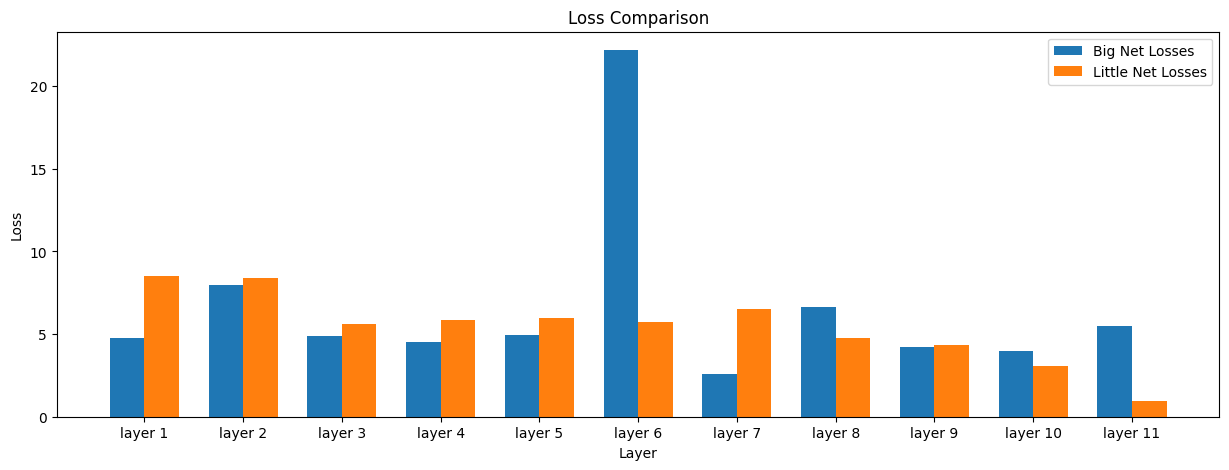

In [ ]:
index = np.arange(11)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15,5))
summer = ax.bar(index, big_losses, bar_width,
                label="Big Net Losses")

winter = ax.bar(index+bar_width, little_losses,
                 bar_width, label="Little Net Losses")

ax.set_xlabel('Layer')
ax.set_ylabel('Loss')
ax.set_title('Loss Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(y.columns)
ax.legend()

plt.show()

In [ ]:
def plot_comparison(pred_big, pred_little, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred_little, 'go', label='little predicted')
    plt.plot(pred_big, 'ro', label='big predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [ ]:
actual_df = y_test

pred_df_big = pd.DataFrame(make_predictions(X_test).detach().numpy())
pred_df_big.columns = actual_df.columns

pred_df_little = pred_df_little.iloc[:, 11:]
pred_df_little.columns = actual_df.columns

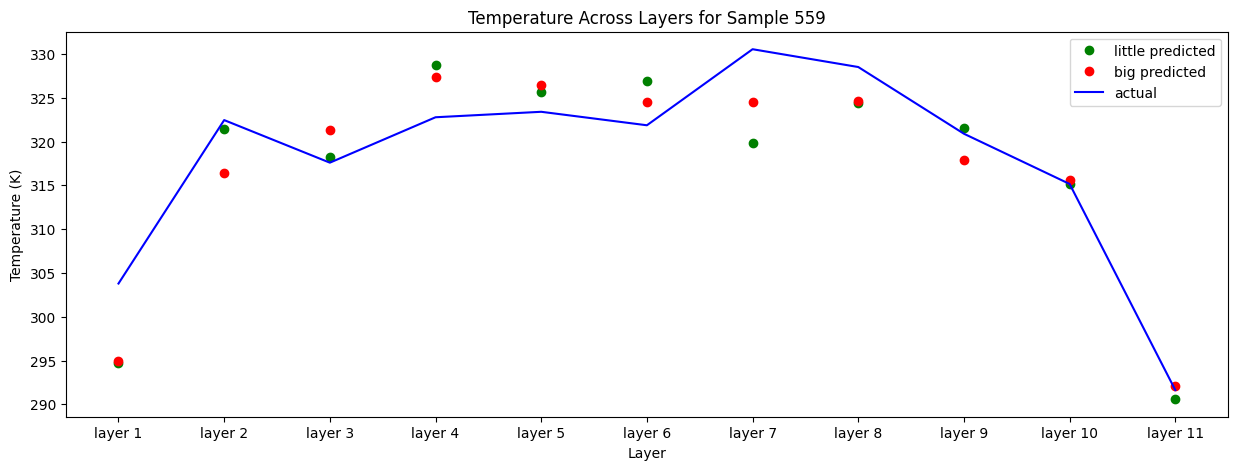

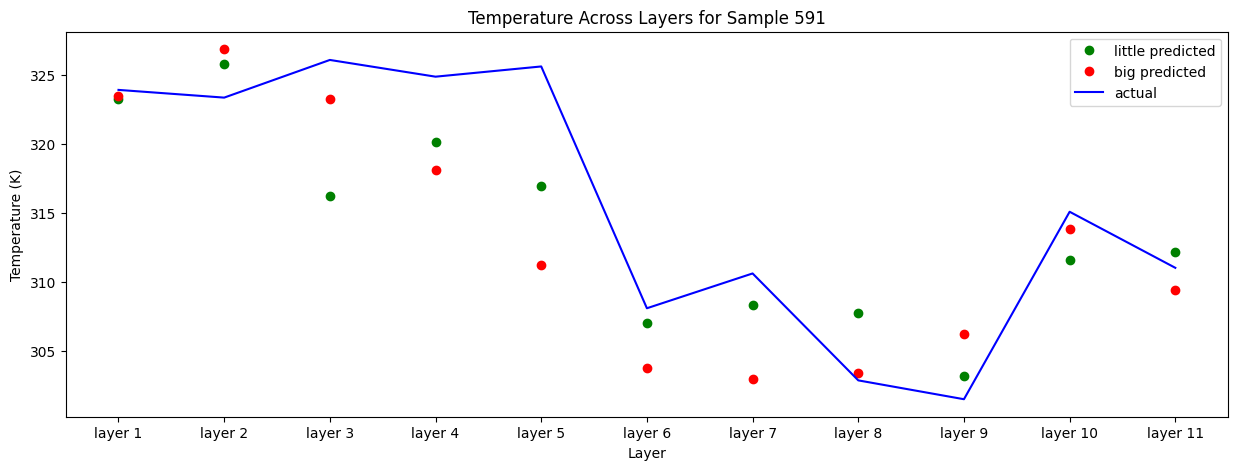

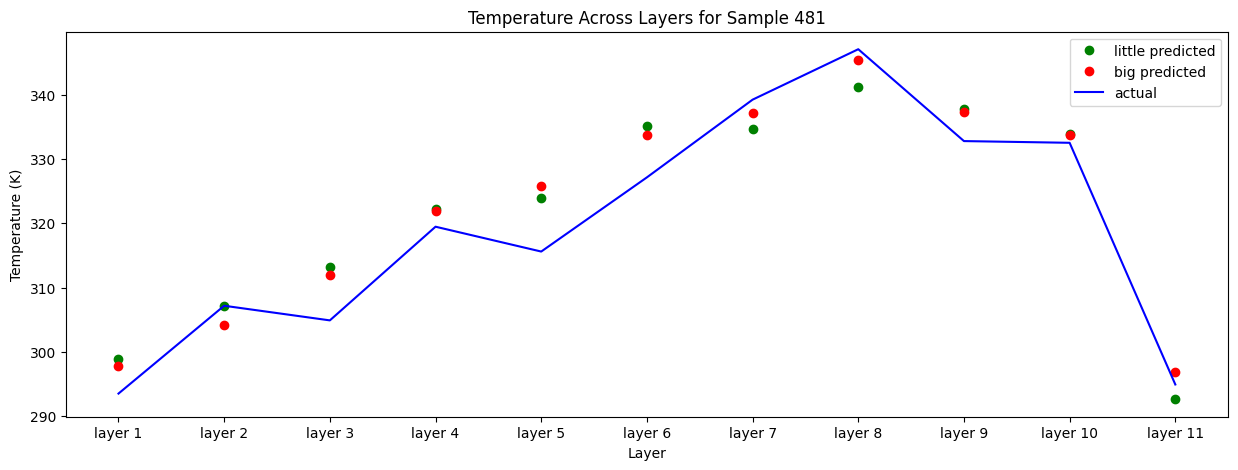

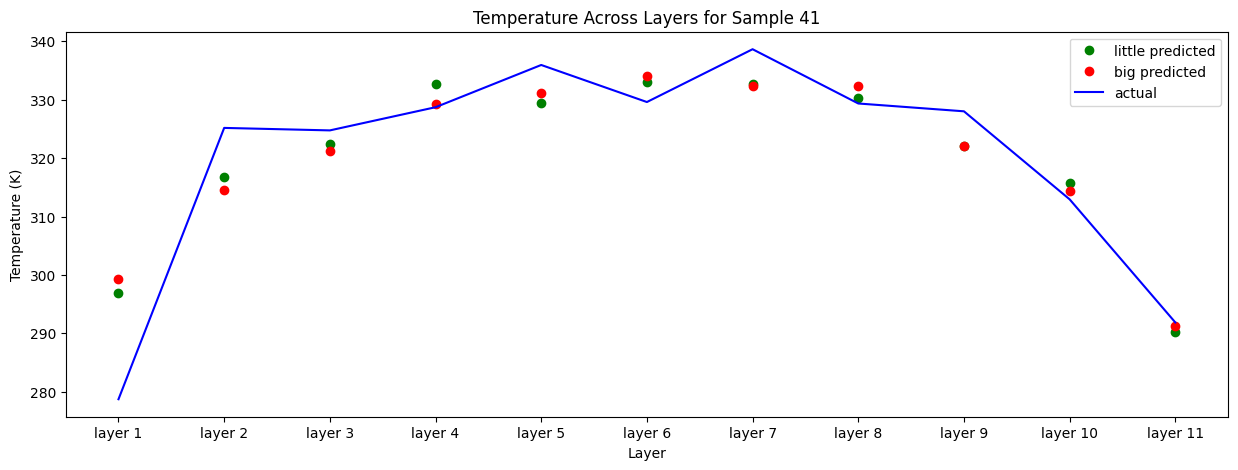

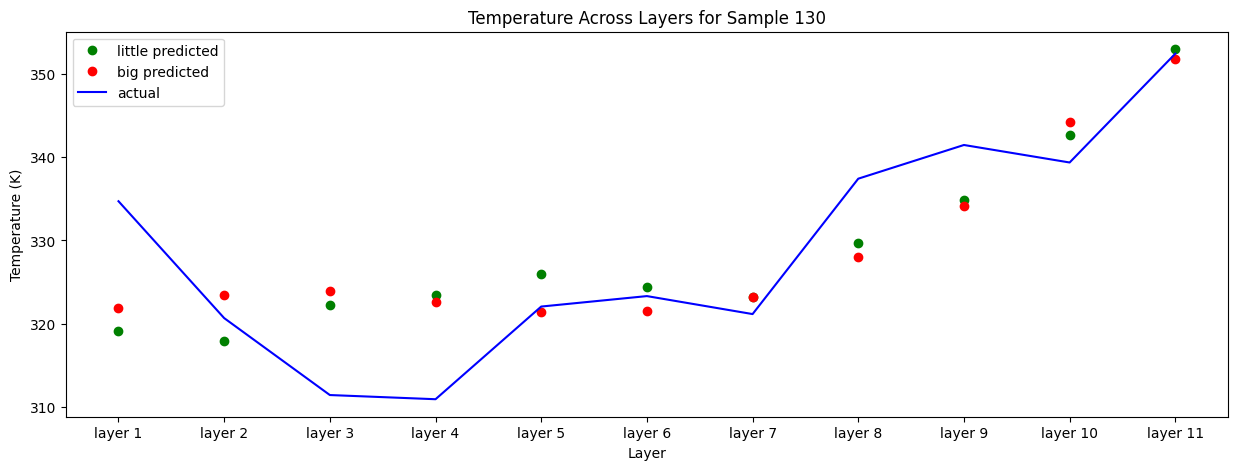

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred_big = pred_df_big.iloc[i,:]
    pred_little = pred_df_little.iloc[i,:]

    plot_comparison(pred_big, pred_little, actual, i)